In [1]:
import cv2
import mediapipe as mp
import numpy as np
import time
from IPython.display import clear_output, display, Image

In [2]:
def calculate_angle(a, b, c):
    """Calculate the angle at point b between points a-b-c in degrees"""
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(np.degrees(radians))
    return 360 - angle if angle > 180 else angle



In [3]:
# Initialize video capture
video_path = "plank_video.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
reported_fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Validate FPS and calculate frame delay
if reported_fps <= 0:
    reported_fps = 30.0
frame_delay = 1.0 / reported_fps

print(f"Video Info: {frame_width}x{frame_height} @ {reported_fps:.2f} FPS")


Video Info: 3840x2160 @ 25.00 FPS


In [4]:
# Pose detection setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Angle thresholds
ELBOW_SHOULDER_HIP_RANGE = (75, 100)    # Elbow-shoulder-hip angle
LOWER_BODY_ANGLE_MIN = 170              # Shoulder-hip-knee and hip-knee-ankle

# Timing variables
hold_start_time = None
current_hold = 0.0
max_hold = 0.0
last_frame_time = time.time()



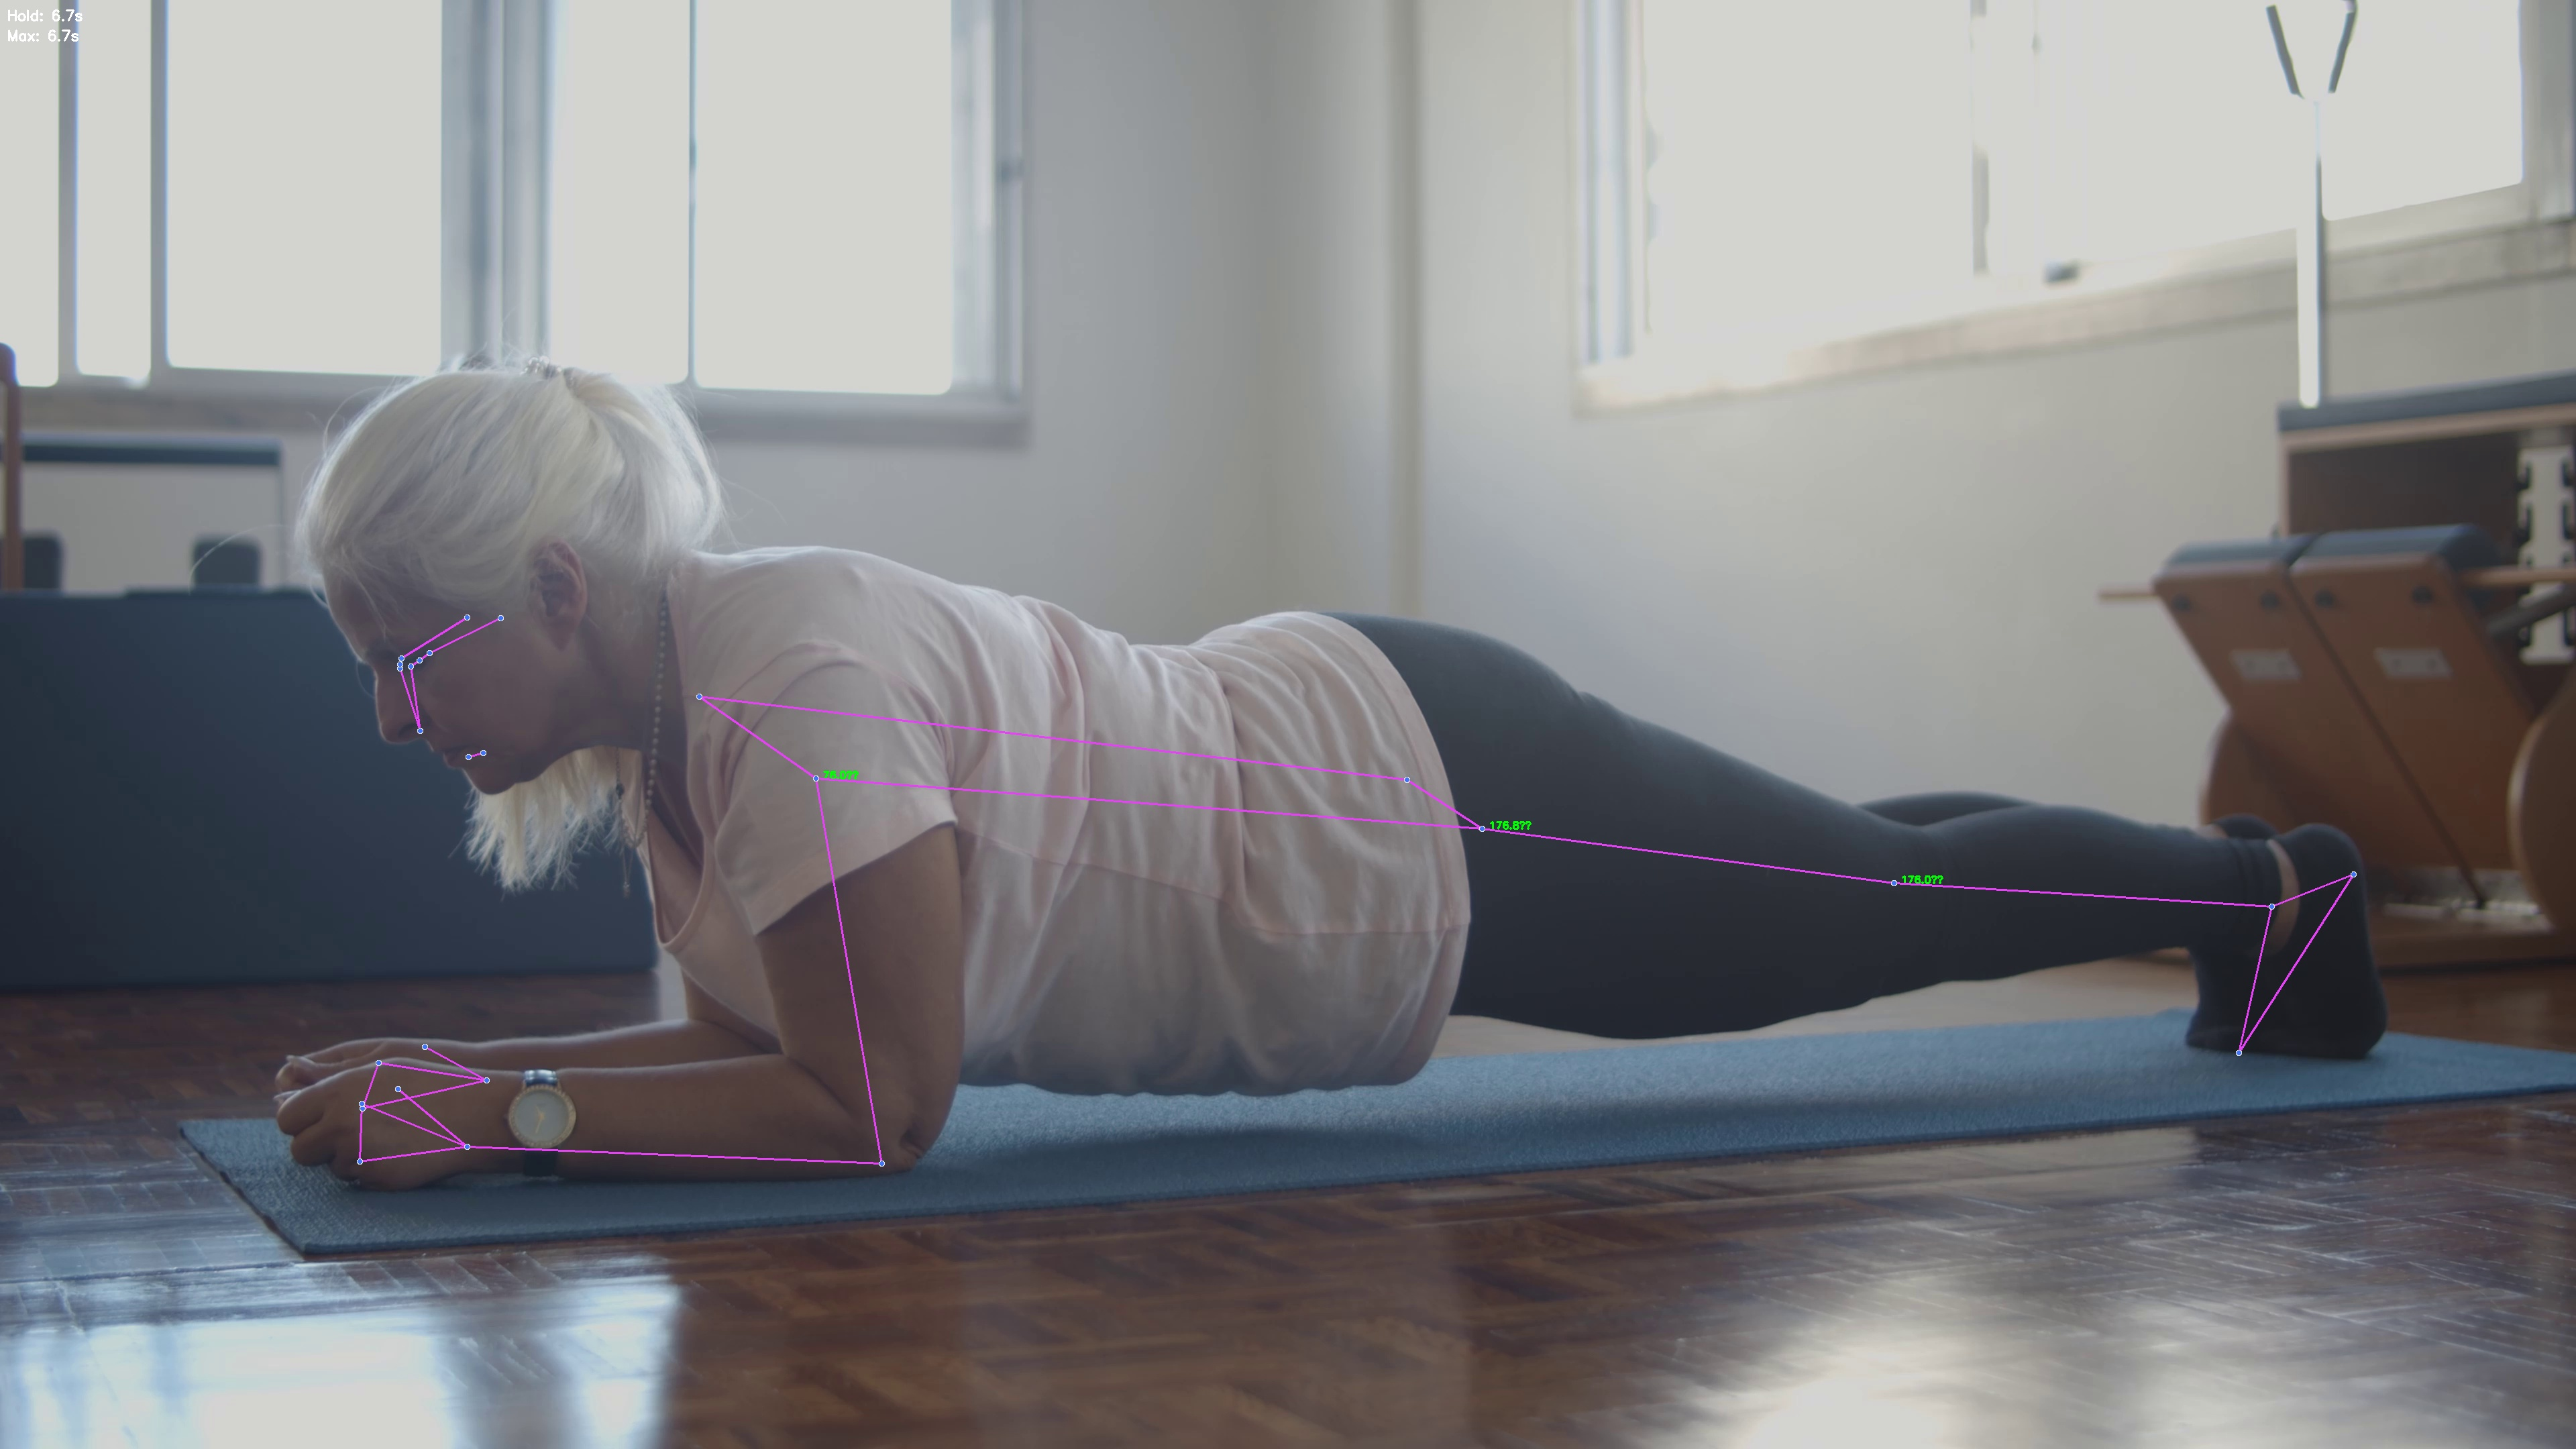

In [5]:
while cap.isOpened():
    # Frame timing control (matches video FPS)
    current_time = time.time()
    elapsed = current_time - last_frame_time
    if elapsed < frame_delay:
        time.sleep(frame_delay - elapsed)
    last_frame_time = time.time()
    
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Get timestamp
    frame_idx = cap.get(cv2.CAP_PROP_POS_FRAMES)
    timestamp = frame_idx / reported_fps

    posture_correct = False
    angles = {'shoulder': 0, 'hip': 0, 'knee': 0}
    
    if results.pose_landmarks:
        try:
            landmarks = results.pose_landmarks.landmark
            h, w = image.shape[:2]
            
            # Get left side landmarks with proper error handling
            keypoints = {
                'elbow': mp_pose.PoseLandmark.LEFT_ELBOW,
                'shoulder': mp_pose.PoseLandmark.LEFT_SHOULDER,
                'hip': mp_pose.PoseLandmark.LEFT_HIP,
                'knee': mp_pose.PoseLandmark.LEFT_KNEE,
                'ankle': mp_pose.PoseLandmark.LEFT_ANKLE
            }
            
            # Convert landmarks to pixel coordinates with existence check
            points = {}
            for name, landmark in keypoints.items():
                lm = landmarks[landmark.value]
                if lm.visibility > 0.5:  # Only use visible landmarks
                    points[name] = (int(lm.x * w), int(lm.y * h))

            # Check if all required points are available
            if all(k in points for k in ['elbow', 'shoulder', 'hip', 'knee', 'ankle']):
                # Calculate angles
                angles['shoulder'] = calculate_angle(
                    points['elbow'], points['shoulder'], points['hip']
                )
                angles['hip'] = calculate_angle(
                    points['shoulder'], points['hip'], points['knee']
                )
                angles['knee'] = calculate_angle(
                    points['hip'], points['knee'], points['ankle']
                )

                # Check posture criteria
                posture_correct = (
                    ELBOW_SHOULDER_HIP_RANGE[0] <= angles['shoulder'] <= ELBOW_SHOULDER_HIP_RANGE[1] and
                    angles['hip'] >= LOWER_BODY_ANGLE_MIN and
                    angles['knee'] >= LOWER_BODY_ANGLE_MIN
                )

                # Draw angles on frame
                color = (0, 255, 0) if posture_correct else (0, 0, 255)
                for name, pos in points.items():
                    if name in angles:
                        cv2.putText(image, f"{angles[name]:.1f}°", 
                                  (pos[0]+10, pos[1]), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                                  color, 2)

        except KeyError as e:
            posture_correct = False

    # Update timer logic
    if posture_correct:
        if hold_start_time is None:
            hold_start_time = timestamp
        current_hold = timestamp - hold_start_time
        max_hold = max(max_hold, current_hold)
    else:
        if hold_start_time is not None:
            # Only update max when breaking the hold
            max_hold = max(max_hold, current_hold)
        hold_start_time = None
        current_hold = 0.0

    # Display info
    cv2.putText(image, f"Hold: {current_hold:.1f}s", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(image, f"Max: {max_hold:.1f}s", (10, 60), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Draw pose landmarks
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
            mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2)
        )

    # Display in Jupyter
    ret, buffer = cv2.imencode('.jpg', image)
    if ret:
        clear_output(wait=True)
        display(Image(data=buffer.tobytes()))


In [6]:
cap.release()
print(f"\nAnalysis Complete!\nMaximum Plank Hold: {max_hold:.1f} seconds")



Analysis Complete!
Maximum Plank Hold: 6.7 seconds
